In [1]:
from IPython.display import clear_output
clear_output()

In [ ]:
import shutil

# Try to remove the tree; if it fails, throw an error using try...except.
try:
    shutil.rmtree("/content/sample_data")
except OSError as e:
    print("Error: %s - %s." % (e.filename, e.strerror))

In [2]:
# Clone from Github Repository
! git init .
! git remote add origin https://github.com/RichardMinsooGo-ML/Bible_4_Part_M_Semantic_Segmentation.git
# ! git pull origin master
! git pull origin main

hint: Using 'master' as the name for the initial branch. This default branch name
hint: is subject to change. To configure the initial branch name to use in all
hint: of your new repositories, which will suppress this warning, call:
hint: 
hint: 	git config --global init.defaultBranch <name>
hint: 
hint: Names commonly chosen instead of 'master' are 'main', 'trunk' and
hint: 'development'. The just-created branch can be renamed via this command:
hint: 
hint: 	git branch -m <name>
Initialized empty Git repository in /content/.git/
remote: Enumerating objects: 19, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 19 (delta 3), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (19/19), 7.99 KiB | 1.60 MiB/s, done.
From https://github.com/RichardMinsooGo-ML/Bible_4_Part_M_Semantic_Segmentation
 * branch            main       -> FETCH_HEAD
 * [new branch]      main       -> origin/main


In [3]:
# VOC 2012 Dataset Download and extract

! wget http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
!tar -xvf "/content/VOCtrainval_11-May-2012.tar" -C "/content/dataset"
clear_output()

In [4]:
# VOC 2007 Dataset Download and extract

! wget http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar
! wget http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtest_06-Nov-2007.tar
!tar -xvf "/content/VOCtrainval_06-Nov-2007.tar" -C "/content/dataset"
!tar -xvf "/content/VOCtest_06-Nov-2007.tar" -C "/content/dataset"
clear_output()

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import random
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn.functional as F
from torchvision.models import vgg16

from src.dataset import COLOR_2_INDEX, CLASS_NAMES
from src.utils import batch_mean_iou

from PIL import Image
import glob
from torch.utils.data import Dataset
import torchvision.transforms.functional as TVF

class PascalVoc(Dataset):
    def __init__(self, path, img_size, device="cuda"):
        self.seg_folder = "SegmentationClass/"
        self.img_folder = "JPEGImages/"
        self.path = path
        self.device = device

        self.segmentation_imgs = glob.glob(path + self.seg_folder + "*")
        self.img_size = img_size

    def __len__(self):
        return len(self.segmentation_imgs)

    def get_paths(self, idx):
        mask_path = self.segmentation_imgs[idx]

        # print("mask_path : " , mask_path)

        file_name = mask_path.split("/")[-1]
        img_path = self.path + self.img_folder + file_name
        img_path = img_path.split(".")[0] + ".jpg"

        # print("img_path  : " , img_path)

        return (img_path, mask_path)

    def load_imgs(self, idx):
        img_path, mask_path = self.get_paths(idx)

        img = Image.open(img_path)
        img = img.resize((self.img_size, self.img_size))

        mask_img = Image.open(mask_path).convert("RGB")
        mask_img = mask_img.resize((self.img_size, self.img_size))

        return (img, mask_img)

    @staticmethod
    def create_label_mask(mask_img):
        mask = np.array(mask_img).astype(int)
        label_mask = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.int16)

        for idx, label in enumerate(COLOR_2_INDEX):
            label_mask[np.where(np.all(mask == label, axis=-1))[:2]] = idx

        label_mask = label_mask.astype(int)
        return label_mask

    def __getitem__(self, idx):
        img, mask_img = self.load_imgs(idx)

        if random.random() > 0.5:
            img = TVF.hflip(img)
            mask_img = TVF.hflip(mask_img)

        mask_img = PascalVoc.create_label_mask(mask_img)
        mask_img = torch.from_numpy(mask_img).long()

        img = TVF.to_tensor(img)
        img = TVF.normalize(img,
                            mean=(0.485, 0.456, 0.406),
                            std=(0.229, 0.224, 0.225)
                           )

        img = img.to(self.device)
        mask_img = mask_img.to(self.device)

        return (img, mask_img)


from pylab import rcParams
%matplotlib inline

path = "dataset/VOCdevkit/VOC2012/"
seed = 42

img_size = 224
device = "cuda"

batch_size = 32
train_dataset = PascalVoc(path, img_size, device=device)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=0)

class trans_conv2d(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.ConvTranspose2d(in_channels, out_channels,
                                       kernel_size=3, stride=2,
                                       padding=1, output_padding=1)

    def forward(self, x):
        x = self.conv(x)
        x = F.relu(x)
        return x

class fcn_8(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.num_classes = num_classes

        # Indicies used for FCN-8
        self.fcn_block_indicies = [(0, 17), (17, 24), (24, 31)]
        self.init_vgg()

        self.pool_5_upsample = trans_conv2d(512, 512)
        self.pool_5_bn = nn.BatchNorm2d(512)

        self.pool_4_upsample = trans_conv2d(512, 256)
        self.pool_4_bn = nn.BatchNorm2d(512)

        self.pool_3_upsample = trans_conv2d(256, 128)
        self.pool_3_bn = nn.BatchNorm2d(256)

        self.upsample_score_1 = trans_conv2d(128, 64)
        self.upsample_score_1_bn = nn.BatchNorm2d(64)

        self.upsample_score_2 = trans_conv2d(64, 32)
        self.upsample_score_2_bn = nn.BatchNorm2d(32)

        self.out_conv = nn.Conv2d(32, self.num_classes, kernel_size=1)

    def init_vgg(self):
        model = vgg16(pretrained=True)
        del model.classifier
        model = model.to(device)

        self.blocks = []

        for block_idx in self.fcn_block_indicies:
            self.blocks.append(model.features[block_idx[0]:block_idx[1]])

        # Freezing the VGG weights
        for block in self.blocks:
            for param in block.parameters():
                param.requires_grad = False

    def forward(self, x):
        x_3 = self.blocks[0](x)
        x_4 = self.blocks[1](x_3)
        x_5 = self.blocks[2](x_4)

        score = self.pool_5_upsample(x_5)
        score = self.pool_5_bn(score)

        score = score + x_4
        score = self.pool_4_bn(score)
        score = self.pool_4_upsample(score)

        score = score + x_3
        score = self.pool_3_bn(score)
        score = self.pool_3_upsample(score)

        score = self.upsample_score_1(score)
        score = self.upsample_score_1_bn(score)

        score = self.upsample_score_2(score)
        score = self.upsample_score_2_bn(score)

        score = self.out_conv(score)
        score = F.log_softmax(score, dim=1)
        return score

torch.manual_seed(seed)
model = fcn_8(len(CLASS_NAMES)).to(device)


In [9]:
num_epochs = 40

lr = 2e-3
wd = 1e-5
gamma = 0.5
step_size = 10

optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
loss_fct = nn.NLLLoss()

from tqdm import tqdm, tqdm_notebook, trange

torch.manual_seed(seed)
model.train()
for epoch in range(num_epochs):
    loss = 0.0
    iou = 0.0

    scheduler.step()

    with tqdm_notebook(total=len(train_dataloader), desc=f"Train {epoch+1}") as pbar:

        for _, (x, y) in enumerate(train_dataloader):
            optimizer.zero_grad()

            y_hat = model(x)
            batch_loss = loss_fct(y_hat, y)

            batch_loss.backward()
            optimizer.step()

            batch_loss = batch_loss.detach().cpu().numpy()
            loss += batch_loss

            preds = torch.argmax(y_hat, dim=1)
            batch_iou = batch_mean_iou(preds.detach().cpu().numpy(), y.detach().cpu().numpy())
            iou += batch_iou

            pbar.update(1)

    loss = loss / len(train_dataloader)
    iou = iou / len(train_dataloader)

    if (epoch+1) % 5 == 0:
        print(f"-------Epoch {epoch+1}-------")
        print(f"Loss : {loss}")
        print(f"Mean IOU: {iou}")


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
<ipython-input-9-802f143e952f>:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  with tqdm_notebook(total=len(train_dataloader), desc=f"Train {epoch+1}") as pbar:


Train 1:   0%|          | 0/92 [00:00<?, ?it/s]

Train 2:   0%|          | 0/92 [00:00<?, ?it/s]

Train 3:   0%|          | 0/92 [00:00<?, ?it/s]

Train 4:   0%|          | 0/92 [00:00<?, ?it/s]

Train 5:   0%|          | 0/92 [00:00<?, ?it/s]

-------Epoch 5-------
Loss : 0.37936829224876734
Mean IOU: 0.6331041655679163


Train 6:   0%|          | 0/92 [00:00<?, ?it/s]

Train 7:   0%|          | 0/92 [00:00<?, ?it/s]

Train 8:   0%|          | 0/92 [00:00<?, ?it/s]

Train 9:   0%|          | 0/92 [00:00<?, ?it/s]

Train 10:   0%|          | 0/92 [00:00<?, ?it/s]

-------Epoch 10-------
Loss : 0.2400419080386991
Mean IOU: 0.7126333025377904


Train 11:   0%|          | 0/92 [00:00<?, ?it/s]

Train 12:   0%|          | 0/92 [00:00<?, ?it/s]

Train 13:   0%|          | 0/92 [00:00<?, ?it/s]

Train 14:   0%|          | 0/92 [00:00<?, ?it/s]

Train 15:   0%|          | 0/92 [00:00<?, ?it/s]

-------Epoch 15-------
Loss : 0.14812025350882954
Mean IOU: 0.7777335650904513


Train 16:   0%|          | 0/92 [00:00<?, ?it/s]

Train 17:   0%|          | 0/92 [00:00<?, ?it/s]

Train 18:   0%|          | 0/92 [00:00<?, ?it/s]

Train 19:   0%|          | 0/92 [00:00<?, ?it/s]

Train 20:   0%|          | 0/92 [00:00<?, ?it/s]

-------Epoch 20-------
Loss : 0.10713554874224507
Mean IOU: 0.810520587271203


Train 21:   0%|          | 0/92 [00:00<?, ?it/s]

Train 22:   0%|          | 0/92 [00:00<?, ?it/s]

Train 23:   0%|          | 0/92 [00:00<?, ?it/s]

Train 24:   0%|          | 0/92 [00:00<?, ?it/s]

Train 25:   0%|          | 0/92 [00:00<?, ?it/s]

-------Epoch 25-------
Loss : 0.08371408999411632
Mean IOU: 0.8340342057657474


Train 26:   0%|          | 0/92 [00:00<?, ?it/s]

Train 27:   0%|          | 0/92 [00:00<?, ?it/s]

Train 28:   0%|          | 0/92 [00:00<?, ?it/s]

Train 29:   0%|          | 0/92 [00:00<?, ?it/s]

Train 30:   0%|          | 0/92 [00:00<?, ?it/s]

-------Epoch 30-------
Loss : 0.07123527424814909
Mean IOU: 0.8485389827655926


Train 31:   0%|          | 0/92 [00:00<?, ?it/s]

Train 32:   0%|          | 0/92 [00:00<?, ?it/s]

Train 33:   0%|          | 0/92 [00:00<?, ?it/s]

Train 34:   0%|          | 0/92 [00:00<?, ?it/s]

Train 35:   0%|          | 0/92 [00:00<?, ?it/s]

-------Epoch 35-------
Loss : 0.0600098983546638
Mean IOU: 0.8632210352929878


Train 36:   0%|          | 0/92 [00:00<?, ?it/s]

Train 37:   0%|          | 0/92 [00:00<?, ?it/s]

Train 38:   0%|          | 0/92 [00:00<?, ?it/s]

Train 39:   0%|          | 0/92 [00:00<?, ?it/s]

Train 40:   0%|          | 0/92 [00:00<?, ?it/s]

-------Epoch 40-------
Loss : 0.05614929196789213
Mean IOU: 0.8682446751282533


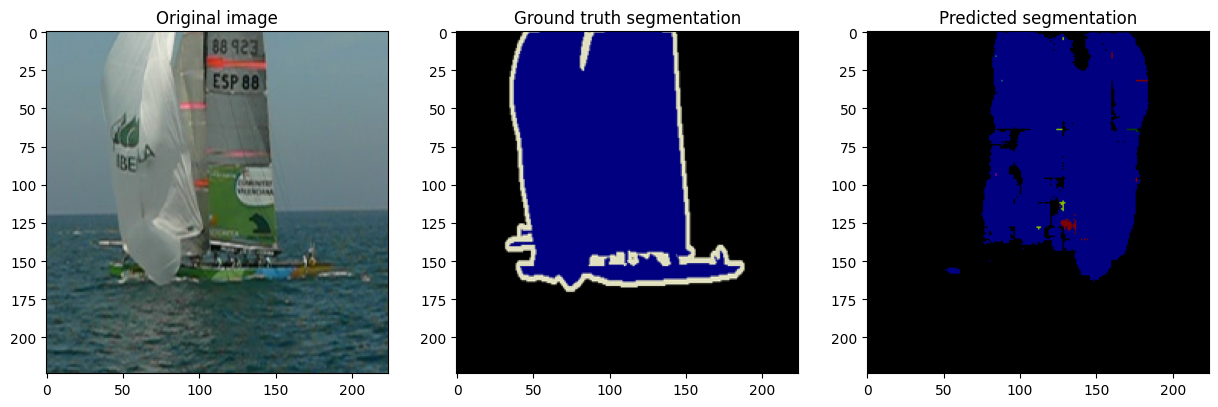

In [10]:
random.seed(seed)
model.eval()

idx = 3
x, _ = train_dataset[idx]
y, _ = train_dataset.load_imgs(idx)
gt = train_dataset.segmentation_imgs[idx]
gt = Image.open(gt).convert("RGB")

x = x.unsqueeze(0)
y_hat = model(x)
y_hat = torch.argmax(y_hat, dim=1)[0, :, :]
y_hat = y_hat.detach().cpu().numpy()

gt = gt.resize((img_size, img_size))
gt = np.array(gt)

y_hat_mask = np.zeros((img_size, img_size, 3))

for i in range(img_size):
    for j in range(img_size):
        y_hat_mask[i, j, :] = COLOR_2_INDEX[y_hat[i, j]]

y_hat_mask = y_hat_mask.astype(int)

rcParams['figure.figsize'] = 15, 15

plt.subplot(1, 3, 1)
plt.imshow(y)
plt.title("Original image")

plt.subplot(1, 3, 2)
plt.imshow(gt)
plt.title("Ground truth segmentation")

plt.subplot(1, 3, 3)
plt.imshow(y_hat_mask)
plt.title("Predicted segmentation")

plt.show()

